In [1]:
from olv_object_detection import load_object_detector

import cv2
import matplotlib.pyplot as plt
import numpy as np
import easyocr
from typing import List, Tuple, Dict
from do_lines_intersect import do_lines_intersect
from pathlib import Path

from olv_draw import draw_bbs, DrawParameters
from PIL import Image, ImageDraw
import math

In [2]:
image_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/testing/0_resized_internearest.jpg")
number_detector_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/full_image_models/object_detection/yolov5/20241112/180906/model.detector")

In [3]:
def rotate(img, angle):
    (height, width) = img.shape[:2]
    (cent_x, cent_y) = (width // 2, height // 2)

    mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
    cos = np.abs(mat[0, 0])
    sin = np.abs(mat[0, 1])

    n_width = int((height * sin) + (width * cos))
    n_height = int((height * cos) + (width * sin))

    mat[0, 2] += (n_width / 2) - cent_x
    mat[1, 2] += (n_height / 2) - cent_y

    return cv2.warpAffine(img, mat, (n_width, n_height))

In [4]:
def rotate_image(image, angle):
        (height, width) = image.shape[:2]
        (cent_x, cent_y) = (width // 2, height // 2)

        # Get the rotation matrix for the given angle
        mat = cv2.getRotationMatrix2D((cent_x, cent_y), -angle, 1.0)
        
        # Calculate the cosine and sine components
        cos = np.abs(mat[0, 0])
        sin = np.abs(mat[0, 1])

        # Compute the new bounding dimensions of the image
        n_width = int((height * sin) + (width * cos))
        n_height = int((height * cos) + (width * sin))

        # Adjust the rotation matrix to account for the change in size
        mat[0, 2] += (n_width / 2) - cent_x
        mat[1, 2] += (n_height / 2) - cent_y

        # Perform the rotation
        rotated = cv2.warpAffine(image, mat, (n_width, n_height))

        # Convert the rotated image to grayscale and apply a binary threshold to find the non-black areas
        # gray = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(rotated, 1, 255, cv2.THRESH_BINARY)

        # Find contours of the non-black areas
        contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Get the bounding box of the largest contour (ignores small noisy areas)
        if contours:
            x, y, w, h = cv2.boundingRect(contours[0])
            # Crop the image to this bounding box
            rotated_cropped = rotated[y:y+h, x:x+w]
        else:
            # If no contours are found, return the rotated image as-is
            rotated_cropped = rotated

        return rotated_cropped

In [5]:
def rotatedRectWithMaxArea(w, h, angle):
  """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.
  """
  if w <= 0 or h <= 0:
    return 0,0

  width_is_longer = w >= h
  side_long, side_short = (w,h) if width_is_longer else (h,w)

  # since the solutions for angle, -angle and 180-angle are all the same,
  # if suffices to look at the first quadrant and the absolute values of sin,cos:
  sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
  if side_short <= 2.*sin_a*cos_a*side_long or abs(sin_a-cos_a) < 1e-10:
    # half constrained case: two crop corners touch the longer side,
    #   the other two corners are on the mid-line parallel to the longer line
    x = 0.5*side_short
    wr,hr = (x/sin_a,x/cos_a) if width_is_longer else (x/cos_a,x/sin_a)
  else:
    # fully constrained case: crop touches all 4 sides
    cos_2a = cos_a*cos_a - sin_a*sin_a
    wr,hr = (w*cos_a - h*sin_a)/cos_2a, (h*cos_a - w*sin_a)/cos_2a

  return wr,hr

def remove_black_outline(w_original, h_original, angle, img_rotated):
    wr, hr = rotatedRectWithMaxArea(w_original, h_original, angle*np.pi/180)
    h, w = img_rotated.shape[:2]

    x1 = int((w-wr)/2)
    x2 = int(x1 + wr)
    y1 = int((h-hr)/2)
    y2 = int(y1 + hr)
    return img_rotated[y1:y2, x1:x2]

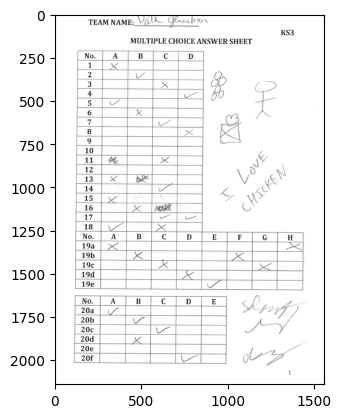

In [6]:

img = cv2.cvtColor(cv2.imread(str(image_path)), cv2.COLOR_BGR2GRAY)
img_cropped = img[210:-210, 100:-100]
angle = 3
h_original, w_original = img_cropped.shape[:2]
# img_cropped = rotate_image(img_cropped, angle)
plt.imshow(img_cropped, cmap="gray")
plt.show()
# img_cropped = remove_black_outline(w_original, h_original, angle, img_cropped)
# plt.imshow(img_cropped, cmap='gray')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


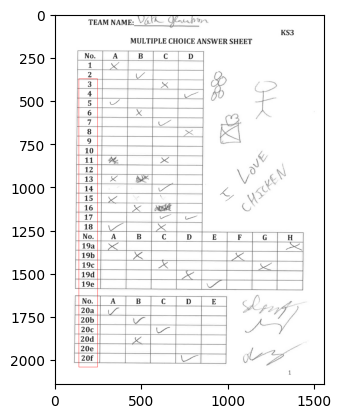

In [7]:
no_detector = load_object_detector(number_detector_path)

number_detections = no_detector.infer_parsed(img_cropped, conf_thres=0.1)

image_pil = Image.fromarray(cv2.cvtColor(img_cropped, cv2.COLOR_GRAY2RGB))
image_canvas = ImageDraw.Draw(image_pil)
draw_parameters = DrawParameters(fill_color=None)

draw_bbs(image_canvas, number_detections, draw_parameters)

plt.imshow(np.array(image_pil))

In [8]:
ocr_box_lines = []
no_ocr_box_y_coords = []
for number_bbox in number_detections:
    bbox_as_array = number_bbox.as_array()
    for i in range(len(bbox_as_array)):
        ocr_box_lines.append([bbox_as_array[i%4], bbox_as_array[(i+1)%4]])
        # ocr_box_lines.append(np.concatenate((bbox_as_array[i%4], bbox_as_array[(i+1)%4]), axis=0))

In [9]:
ocr_box_lines

[[array([137.90855, 374.30417], dtype=float32),
  array([246.71863, 374.30417], dtype=float32)],
 [array([246.71863, 374.30417], dtype=float32),
  array([ 246.71863, 2042.3142 ], dtype=float32)],
 [array([ 246.71863, 2042.3142 ], dtype=float32),
  array([ 137.90855, 2042.3142 ], dtype=float32)],
 [array([ 137.90855, 2042.3142 ], dtype=float32),
  array([137.90855, 374.30417], dtype=float32)]]

In [17]:
image = cv2.GaussianBlur(img_cropped, (5, 5), 0)
edges = cv2.Canny(image, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges,1,np.pi/180,130, None, 0, 0)

In [ ]:
# # remove all lines that cross through any ocr box line
# h, w = image.shape[:2]

# intersection_counts_dict = {i:0 for i in range(len(lines))}
# for line_idx, line in enumerate(lines):
#     rho,theta = line[0]
#     a = np.cos(theta)
#     b = np.sin(theta)
#     x0 = a*rho
#     y0 = b*rho
#     x1 = int(x0 + 2*w*(-b))
#     y1 = int(y0 + 2*h*(a))
#     x2 = int(x0 - 2*w*(-b))
#     y2 = int(y0 - 2*h*(a))

#     for ocr_box_line in ocr_box_lines:
#         ocr_box_line_input = [ocr_box_line[0][0], ocr_box_line[0][1], ocr_box_line[1][0], ocr_box_line[1][1]]

#         if do_lines_intersect(ocr_box_line_input, [x1, y1, x2, y2]):
#             intersection_counts_dict[line_idx] += 1

# indices_to_remove = []

# for line_idx in intersection_counts_dict:
#     if intersection_counts_dict[line_idx] > 2:
#         indices_to_remove.append(line_idx)

# lines = np.delete(lines, indices_to_remove, axis=0)



In [19]:
h, w = image.shape[:2]

vertical_thetas = []
horizontal_thetas = []
for i in range(lines.shape[0]):
    if lines[i][0][1] > np.pi/4 and lines[i][0][1] < (3*np.pi)/4:
        horizontal_thetas.append(lines[i][0][1])
    else:
        vertical_thetas.append(lines[i][0][1])

for i in range(len(vertical_thetas)):
    if vertical_thetas[i] > np.pi/2:
        vertical_thetas[i] -= np.pi

# find the median values and remove outliers
horizontal_thetas.sort()
horizontal_theta = horizontal_thetas[len(horizontal_thetas)//2]

vertical_theta = horizontal_theta - np.pi/2

indices_to_delete = []
for i in range(lines.shape[0]):
    if abs(lines[i][0][1] - horizontal_theta) > np.pi/360 and abs(lines[i][0][1] - vertical_theta) > np.pi/360:
        indices_to_delete.append(i)

lines = np.delete(lines, indices_to_delete, axis=0)

number of Hough lines: 189
Number of filtered lines: 53


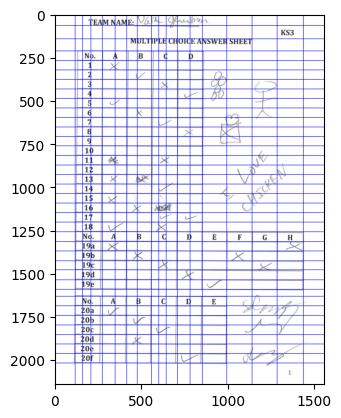

In [21]:
to_filter = True

if to_filter:
    rho_threshold = 40
    theta_threshold = 0.7

    # how many lines are similar to a given one
    similar_lines = {i : [] for i in range(len(lines))}
    for i in range(len(lines)):
        for j in range(len(lines)):
            if i == j:
                continue
            
            lines[i][0][0] = np.abs(lines[i][0][0])
            lines[j][0][0] = np.abs(lines[j][0][0])

            rho_i,theta_i = lines[i][0]
            rho_j,theta_j = lines[j][0]

            if abs(rho_i - rho_j) < rho_threshold and (abs(theta_i - theta_j) < theta_threshold or (np.pi - abs(theta_i - theta_j)) < theta_threshold):
                similar_lines[i].append(j)

    # ordering the INDECES of the lines by how many are similar to them
    indices = [i for i in range(len(lines))]
    indices.sort(key=lambda x : len(similar_lines[x]))

    # line flags is the base for the filtering
    line_flags = len(lines)*[True]
    for i in range(len(lines) - 1):
        if not line_flags[indices[i]]: # if we already disregarded the ith element in the ordered list then we don't care (we will not delete anything based on it and we will never reconsider using this line again)
            continue

        for j in range(i + 1, len(lines)): # we are only considering those elements that had less similar line
            if not line_flags[indices[j]]: # and only if we have not disregarded them already
                continue

            rho_i,theta_i = lines[indices[i]][0]
            rho_j,theta_j = lines[indices[j]][0]
            if abs(rho_i - rho_j) < rho_threshold and (abs(theta_i - theta_j) < theta_threshold or (np.pi - abs(theta_i - theta_j)) < theta_threshold):
                line_flags[indices[j]] = False # if it is similar and have not been disregarded yet then drop it now

print('number of Hough lines:', len(lines))

filtered_lines = []

if to_filter:
    for i in range(len(lines)): # filtering
        if line_flags[i]:
            filtered_lines.append(lines[i])

    print('Number of filtered lines:', len(filtered_lines))
else:
    filtered_lines = lines

image_with_lines = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
filtered_lines_cartesian = []
for line in filtered_lines:
    rho,theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + 4000*(-b))
    y1 = int(y0 + 4000*(a))
    x2 = int(x0 - 4000*(-b))
    y2 = int(y0 - 4000*(a))

    cv2.line(image_with_lines,(x1,y1),(x2,y2),(0,0,255),2)

    filtered_lines_cartesian.append([x1, y1, x2, y2])

plt.imshow(image_with_lines)


In [ ]:
# crop all questions according to the coordinates
# TODO: find the intersections for all lines, and use this to calculate the centres for answers for each question row later on

from olv_primitives import Bbox

# split into vertical and horizontal lines
vertical_lines = []
horizontal_lines = []

for line in filtered_lines_cartesian:
    if abs(line[0]-line[2]) > abs(line[1]-line[3]):
        horizontal_lines.append(line)
    else:
        vertical_lines.append(line)
# remove middle vertical lines
vertical_lines = [vertical_line for vertical_line in vertical_lines if vertical_line[0] > 0]
vertical_lines.sort(key=lambda x : x[0])
num_vertical_lines = len(vertical_lines)
# vertical_lines = [vertical_lines[0]] + [vertical_lines[-1]]

# find the No. OCR coords
horizontal_lines = [horizontal_line for horizontal_line in horizontal_lines] # if horizontal_line[1] > min(no_ocr_box_y_coords)-70]

In [ ]:
# remove all lines that cross through any ocr box line
h, w = image.shape[:2]

intersection_counts_dict = {i:0 for i in range(len(lines))}
for line_idx, line in enumerate(vertical_lines):
    for ocr_box_line in ocr_box_lines:
        ocr_box_line_input = [ocr_box_line[0][0], ocr_box_line[0][1], ocr_box_line[1][0], ocr_box_line[1][1]]

        if do_lines_intersect(ocr_box_line_input, line):
            intersection_counts_dict[line_idx] += 1

indices_to_remove = []

for line_idx in intersection_counts_dict:
    if intersection_counts_dict[line_idx] > 0:
        indices_to_remove.append(line_idx)

vertical_lines = [vertical_line for idx, vertical_line in enumerate(vertical_lines) if idx not in indices_to_remove] 


In [ ]:
image_with_lines2 = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for line in vertical_lines:
    x1, y1, x2, y2 = line
    cv2.line(image_with_lines2,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(image_with_lines2)

In [ ]:
def avg_x(vertical_line: List[float]):
    return (vertical_line[0] + vertical_line[2])/2

vertical_line_spacing = [avg_x(vertical_lines[1:][i+1]) - avg_x(vertical_lines[1:][i]) for i in range(len(vertical_lines[1:])-1)]
vertical_line_spacing.sort()
vertical_line_median = vertical_line_spacing[len(vertical_lines[1:]) // 2]

new_vertical_lines = [vertical_lines[1]]
for i in range(len(vertical_lines[1:])):
    predicted_xloc = new_vertical_lines[-1][0] + vertical_line_median
    for vertical_line in vertical_lines:
        if abs(avg_x(vertical_line) - predicted_xloc) < vertical_line_median/8:
            new_vertical_lines.append(vertical_line)
            break

vertical_lines = [vertical_lines[0]] + new_vertical_lines

In [ ]:
vertical_line_spacing

In [ ]:
image_with_lines2 = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
for line in vertical_lines:
    x1, y1, x2, y2 = line
    cv2.line(image_with_lines2,(x1,y1),(x2,y2),(0,0,255),2)

plt.imshow(image_with_lines2)

In [ ]:
from collections import defaultdict


def line_intersection(line1, line2):

    x1, y1, x2, y2 = line1
    x3, y3, x4, y4 = line2
    # Calculate the denominators and numerators for intersection formula
    denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
    if denominator == 0:
        return None  # Lines are parallel or collinear

    # Calculate the intersection point
    intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
    intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator
    
    # Check if the intersection point is within both line segments
    if (min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and
        min(x3, x4) <= intersect_x <= max(x3, x4) and min(y3, y4) <= intersect_y <= max(y3, y4)):
        return (intersect_x, intersect_y)
    
    return None  # The intersection is outside the segment bounds

def find_intersections(horizontal_lines: List[List[int]], vertical_lines: List[List[int]]) -> List[Bbox]:
    # sort both
    horizontal_lines.sort(key=lambda x: x[1])
    vertical_lines.sort(key= lambda x: x[0])

    intersection_points_by_idx = defaultdict(list)
    for vline_idx, vertical_line in enumerate(vertical_lines):
        for horizontal_line in horizontal_lines:
            intersection_point = line_intersection(horizontal_line, vertical_line)

            if intersection_point is not None:
                intersection_points_by_idx[vline_idx].append(intersection_point)
    
    for vline_idx in intersection_points_by_idx:
        assert len(intersection_points_by_idx[vline_idx]) == len(horizontal_lines)
    
    class_midpoints_by_horizontal_line = defaultdict(list)
    for i in range(len(horizontal_lines)):
        for vline_idx in intersection_points_by_idx:
            if vline_idx == 0 or vline_idx == len(intersection_points_by_idx) - 1:
                continue
            class_midpoints_by_horizontal_line[i].append((intersection_points_by_idx[vline_idx][i][0] + intersection_points_by_idx[vline_idx+1][i][0])/2 - intersection_points_by_idx[0][i][0])
    
    coords1 = intersection_points_by_idx[0]
    coords2 = intersection_points_by_idx[len(vertical_lines) - 1]
    assert len(coords1) == len(coords2)
    output = []
    for i in range(len(coords1)):
        try:
            output.append((coords1[i], coords2[i+1]))
        except IndexError:
            pass
    
    output_parsed = [Bbox.from_absolute(xtl, ytl, xbr, ybr, w, h) for ((xtl, ytl), (xbr, ybr)) in output]

    return output_parsed, class_midpoints_by_horizontal_line

In [ ]:
all_lines = horizontal_lines + vertical_lines
crop_bboxes, class_midpoints = find_intersections(horizontal_lines, vertical_lines)

In [ ]:
image_with_boxes = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_GRAY2RGB))
image_canvas = ImageDraw.Draw(image_pil)
draw_parameters = DrawParameters(fill_color=None)

draw_bbs(image_canvas, crop_bboxes, draw_parameters)

plt.imshow(np.array(image_pil))


In [ ]:
from pathlib import Path

cropped_image_save_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/cropped_data/images")

In [ ]:
import pandas as pd

In [ ]:
detector_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/models/object_detection/yolov5/20241106/192000/model.detector")
detector = load_object_detector(detector_path)

df_cols = [chr(ord('A') + i) for i in range(num_vertical_lines - 2)]
df = pd.DataFrame(columns=df_cols)

label_box = True
image_image_folder = cropped_image_save_path / image_path.stem
image_image_folder.mkdir(parents=True, exist_ok=True)
for i, bbox in enumerate(crop_bboxes):
    bbox_cropped_image = image[int(bbox.ytl):int(bbox.ybr), int(bbox.xtl):int(bbox.xbr)]
    if label_box is True:
        label_box = False
        continue

    centres_for_answers = {mid:cls for mid, cls in zip(class_midpoints[i], df_cols)}
    new_row = {col_value: " " for col_value in df_cols}
    detections = detector.infer_parsed(bbox_cropped_image)

    has_question_number = False
    for detection in detections:
        if detection.label == "question_number" and detection.mid.x < 200:
            has_question_number = True
    
    if not has_question_number:
        continue

    for detection in detections:
        if detection.conf < 0.63 or detection.label != "answer":
            continue

        centre_x = detection.mid.x
        diff = np.Inf
        for answer_x in centres_for_answers:
            diff_ans = abs(centre_x-answer_x)
            if diff_ans < diff:
                answer = centres_for_answers[answer_x]
                diff = diff_ans

        new_row[answer] = "X"

    df.loc[len(df)] = list(new_row.values())
    # try:
    #     image_name = reader.readtext(bbox_cropped_image)[0][1]
    #     image_save_path = image_image_folder / f"{image_name}.jpg"

    #     cv2.imwrite(str(image_save_path), bbox_cropped_image)
    # except:
    #     pass

# Create a plot and hide the axes
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))  # Set the figure size

# Hide the axes
ax[0].axis('off')
ax[1].axis('off')

# Create the table and add it to the plot
table = ax[0].table(cellText=df.values, colLabels=df.columns, loc='center', cellLoc='center', colColours=["lightgray"]*df.shape[1])

# Customize the table (optional)
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)

ax[1].imshow(img_cropped, cmap="gray")

# Display the plot
plt.show()

In [ ]:
# csv_folder_path = Path("/home/oliver/Oliver.Mono/projects/Vision.OPT_MULT/data/csvs")

# csv_file_path = csv_folder_path /  f"{image_path.stem}.csv"


# df.to_csv(csv_file_path)